# <center> Railroad Segmentation (using SMP) </center>

In [ ]:
!pip install -U segmentation-models-pytorch

In [1]:
import segmentation_models_pytorch as SMP
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import os

#### Constants

In [34]:
GOOGLE_COLAB = False

DATA_DIR = 'segmentation/data/segmentation_data/'
if not GOOGLE_COLAB:
    DATA_DIR = os.path.realpath(DATA_DIR)

FEATURES = ['roads', 'railroads', 'wetlands']
POSITIVE = 'railroads'
NEGATIVE = [feature for feature in FEATURES if feature != POSITIVE]

N_SAMPLES = 400 # for each class
N_AUG_POS = 4
N_AUG_NEG = 0
N_POS = N_SAMPLES // N_AUG_POS
N_NEG = N_SAMPLES

BATCH_SIZE = 10

ROTATION_RANGE = 180
WINDOW_SIZE = 320

N_WORKERS = 2

N_EPOCHS = 10
LEARNING_RATE = 0.0001
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
AUX_BRANCH = None

LOAD_MODEL = False
LOAD_MODEL_PATH = 'checkpoints/%s_best.pth'
CHECKPOINTS_DIR = 'checkpoints/'
SAVE_MODEL_PATH = os.path.join(CHECKPOINTS_DIR, '%s_best.pth')

MASK_THRESHOLD = 0.5

NORMALIZE = True

N_CLASSES = 2
MAKE_ONE_HOT = (True if N_CLASSES > 1 else False)

#### Settings for Google Collaboratory

In [3]:
if GOOGLE_COLAB:
    from google.colab import drive
    
    DATA_DIR = 'segmentation_data/'

    drive.mount('/content/drive/')
    os.chdir('/content/drive/My Drive')

    assert os.path.exists(DATA_DIR), 'DATA_DIR does not exist in path'
    assert os.path.exists(CHECKPOINTS_DIR), 'CHECKPOINTS_DIR does not exist'
    
    import sys
    sys.path.append('/content/drive/My Drive')
    
    N_WORKERS = 4
    BATCH_SIZE = 32
    

In [4]:
from data_handler import get_data, sample_points
from transformer import SegmentationTransform
from utils import *

#### Starting with data

- Read dir to gather files
- Maps start with 'map_'
- Masks start with 'mask_'
- Rest have class type in their names
    - eg. railroads.txt

In [5]:
maps, masks, neg_files = get_filepaths(DATA_DIR, POSITIVE, NEGATIVE)

- Load maps and masks
- Caching them since maps are heavy (heavy IO)

In [6]:
LOADED_MAPS = load_images(maps)
LOADED_MASKS = load_images(masks, grayscale=True)
LOADED_MAPS[0].shape, LOADED_MASKS[0].shape

((8042, 6596, 3), (8042, 6596))

In [7]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(16,5))
# plt.subplot(1,2,1)
# plt.imshow(LOADED_MAPS[1])
# plt.subplot(1,2,2)
# plt.imshow(LOADED_MASKS[1], cmap='gray')
# plt.show()

- Sample N_POS pixels (white) from all the pixels that belong to the positive class and write to pos.txt
- Sample N_NEG pixels (black) for each of the negative class and write to neg{}.txt

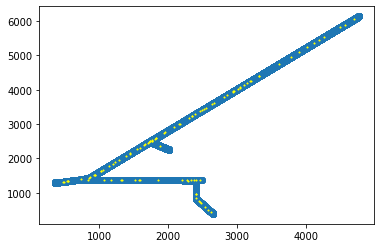

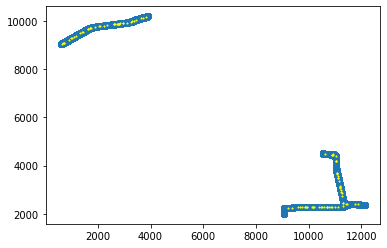

In [8]:
sample_points(maps, masks, neg_files, N_POS, N_NEG, representors=False, plot_pos=True)

#### Create Datasets and Data Loaders

In [9]:
class SegmentationDataset(Dataset):
	def __init__(self, data_points, transformer, win_size, scale=False):
		self.dataset = data_points
		self.transformer = transformer
		self.win_size = win_size
		self.scale = scale
		
	def preprocess(self, data_point):
		data_point = self.transformer(data_point)
		# mask channels == n_classes?
		
#         data_point['image'] = data_point['mask'].to(torch.float64)
#         data_point['mask'] = data_point['mask'].to(torch.long)
#         if self.scale: # totensor transform has done that for us
#             data_point['image'] /= 255.
#             data_point['mask'] /= 255
		return data_point
		
	def __len__(self):
		return len(self.dataset)
	
	def __getitem__(self, ix):
		assert ix < self.__len__(), 'Index must be within bounds (<len)'
		sample = self.preprocess(self.dataset[ix])
		return sample['images'], sample['masks']

In [10]:
# Default: val_size=0.1, shuffle=True, augment=True

train_data, val_data = get_data(maps, LOADED_MAPS, N_AUG_POS, N_AUG_NEG, WINDOW_SIZE, ROTATION_RANGE)
n_train, n_val = len(train_data), len(val_data)
n_train, n_val

(1620, 180)

In [23]:
image_tf, normalizer = None, None
    
if NORMALIZE:
    # using contrast as normalization suppresses the railroad black pixels
    normalizer = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    image_tf = transforms.Lambda(lambda x: TF.adjust_contrast(x, contrast_factor=2))
    
transformer = SegmentationTransform(LOADED_MAPS, LOADED_MASKS, WINDOW_SIZE,
                                    image_tf=image_tf, normalizer=normalizer,
                                   make_one_hot=MAKE_ONE_HOT)

In [24]:
train_dataset = SegmentationDataset(train_data, transformer, WINDOW_SIZE)
val_dataset = SegmentationDataset(val_data, transformer, WINDOW_SIZE)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=N_WORKERS, drop_last=True, pin_memory=True)

#### Simple Tests

815


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(320, 320, 1)


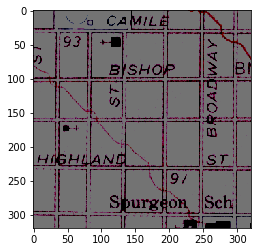

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(320, 320, 1)


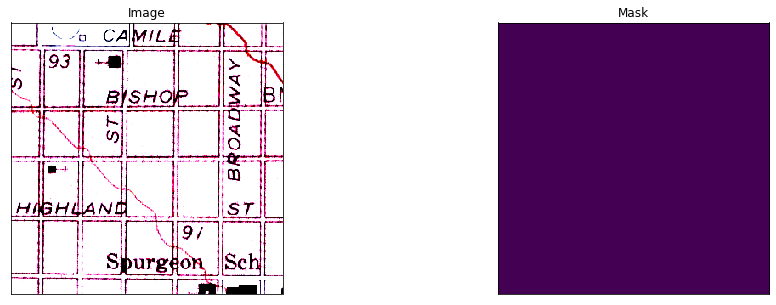

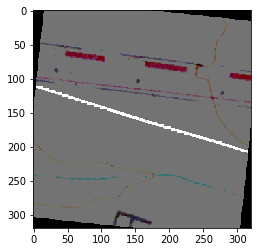

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


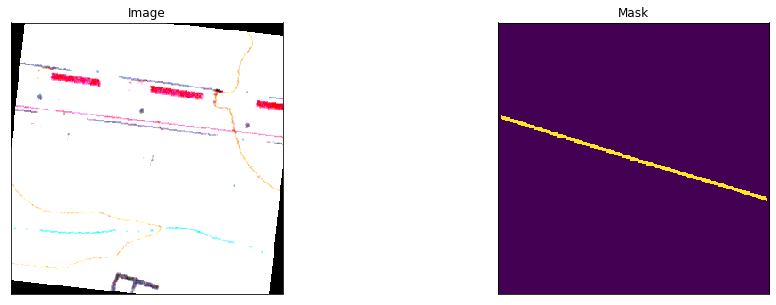

In [31]:
for i in np.random.choice(n_train, 2):
    print(i)
    image, mask = train_dataset[i]
    image = image.numpy().transpose((1,2,0))
    mask = mask.numpy().transpose((1,2,0))
    print(mask.shape)
    if mask.shape[-1] > 1:
        mask = np.argmax(mask, axis=-1)
    else:
        mask = mask.squeeze(-1)
    plot_overlay(image, mask)
    plot_segmentation_row(image=image, mask=mask)

### Load Model

In [33]:
MODEL_NAME = 'unet_resnext50_32x4d'
activation = 'softmax2d' if (N_CLASSES > 1) else 'sigmoid'

model = SMP.Unet(encoder_name='resnext50_32x4d', encoder_weights='imagenet', classes=N_CLASSES, activation=activation)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /Users/Pratulya/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


In [18]:
LOAD_MODEL = False

if LOAD_MODEL:
    model = torch.load(LOAD_MODEL_PATH % MODEL_NAME, map_location=DEVICE)
    
model = model.to(device=DEVICE)

### Training

In [36]:
LEARNING_RATE = 0.01

metrics = [
    SMP.utils.metrics.IoU(threshold=0.5),
    SMP.utils.metrics.Accuracy(threshold=0.5)
]

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

lr_lambda = lambda e: ((1-float(e)/N_EPOCHS)**0.9) # * LEARNING_RATE
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1)

criterion = SMP.utils.losses.BCELoss()
# criterion = SMP.utils.losses.DiceLoss()

writer = SummaryWriter()

In [ ]:
EARLY_STOPPING_PATIENCE = 1

monitor = {'val_loss': np.inf, 'val_score': -np.inf, 'patience': EARLY_STOPPING_PATIENCE, 'best_score': -np.inf}

In [21]:
trainer = SMP.utils.train.TrainEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

validator = SMP.utils.train.ValidEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

In [22]:
LOAD_MODEL_PATH % MODEL_NAME, SAVE_MODEL_PATH % MODEL_NAME

('checkpoints/pspnet_resnet50_best.pth',
 'checkpoints/pspnet_resnet50_best.pth')

In [20]:
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 50226), started 1 day, 9:40:42 ago. (Use '!kill 50226' to kill it.)

In [42]:
def run(start_epoch, lr=None):
    
    for epoch in range(start_epoch, N_EPOCHS):
        print(f"Epoch {epoch}   lr {optimizer.param_groups[0]['lr']}")

        if epoch == start_epoch and lr is not None:
            optimizer.param_groups[0]['lr'] = lr

        train_logs = trainer.run(train_loader)
        valid_logs = validator.run(val_loader)

    #   scheduler.step(valid_logs['dice_loss'])
        scheduler.step(valid_logs['bce_loss'])

    #   writer.add_scalar('dice_loss/train', train_logs['dice_loss'], epoch)
    #   writer.add_scalar('dice_loss/test', valid_logs['dice_loss'], epoch)
        writer.add_scalar('bce_loss/train', train_logs['bce_loss'], epoch)
        writer.add_scalar('bce_loss/test', valid_logs['bce_loss'], epoch)
        writer.add_scalar('iou_score/train', train_logs['iou_score'], epoch)
        writer.add_scalar('iou_score/test', valid_logs['iou_score'], epoch)
        writer.add_scalar('accuracy/train', train_logs['accuracy'], epoch)
        writer.add_scalar('accuracy/test', valid_logs['accuracy'], epoch)
        writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)

        # Early stopping
        prev_loss = monitor['val_loss']
        curr_loss = valid_logs['bce_loss']
    #   curr_loss = valid_logs['dice_loss']

        if curr_loss > prev_loss:
            if monitor['patience'] == 0:
                print("---- TRAINING STOPPED ----")
                break
            else:
                print(f"Monitoring for {monitor['patience']} more epoch(s)")
                monitor['patience'] -= 1
        else:
            monitor['patience'] = EARLY_STOPPING_PATIENCE

        # Save best model
        prev_score = monitor['best_score']
        curr_score = valid_logs['iou_score']

        if curr_score > prev_score:
            monitor['best_score'] = curr_score
            torch.save(model, SAVE_MODEL_PATH % MODEL_NAME)

        monitor['val_loss'] = curr_loss
        monitor['val_score'] = curr_score

In [ ]:
run(start_epoch=0)